# Navenet V4

Disparity Based anomaly detection for navigation

In [1]:
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


### Prepare Data

In [2]:
train_path = "/home/michael/Desktop/BytesDB_train_normal/"
test_normal_path = "/home/michael/Desktop/BytesDB_test_normal/"
test_anormal_path = "/home/michael/Desktop/BytesDB_test_anormal/"

train_data =  utils.BytesDataset(train_path, crop=90)
test_normal_data  =  utils.BytesDataset(test_normal_path, crop=90)
test_anormal_data  =  utils.BytesDataset(test_anormal_path, crop=90)

In [3]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, patch_shape=(3,32,32), path_length=30, collision_buffering=35, vertical_crop=90, robot_width=0.6, batch_size=16):
    while True:
        
        # create memory for training data
        patches = torch.zeros((batch_size, patch_shape[0], patch_shape[1], patch_shape[2]))
        labels = torch.zeros((batch_size, 1))
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source) and dataset.index_exists(rand_source+1):
                target = min(rand_source + path_length, dataset.get_next_break(rand_source)-collision_buffering-1)
                if target - rand_source > 0:
                    try:
                        
                        # Add data into batch
                        path = dataset.path_source_to_target(rand_source, target)
                        
                        left_image = dataset.read_torch_image(rand_source)
                        left_mask = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(left_image.shape[1], left_image.shape[2], left_image.shape[0]))).transpose(0,2).transpose(1,2)
                        
                        is_random = random.randint(0,1)
                        
                        if(is_random):
                            patches[i] = utils.process_image((np.random.rand(patch_shape[1], patch_shape[2], patch_shape[0])*225).astype(np.uint8))
                            labels[i] = 0 
                        else:       
                            # Grab a patch from this image
                            left = int(left_image.shape[2]/2-patch_shape[1]/2)
                            bottom = int(left_image.shape[1] - patch_shape[1])
                            right = int(left_image.shape[2]/2+patch_shape[1]/2)
                            top = left_image.shape[1]
                            patches[i] = (left_image)[:,bottom:top,left:right]
                            labels[i] = 1 
                    
                        i += 1
                    except Exception as e:
                        pass
                        
        yield patches, labels

In [4]:
patches, labels = next(batch_generator(train_data))

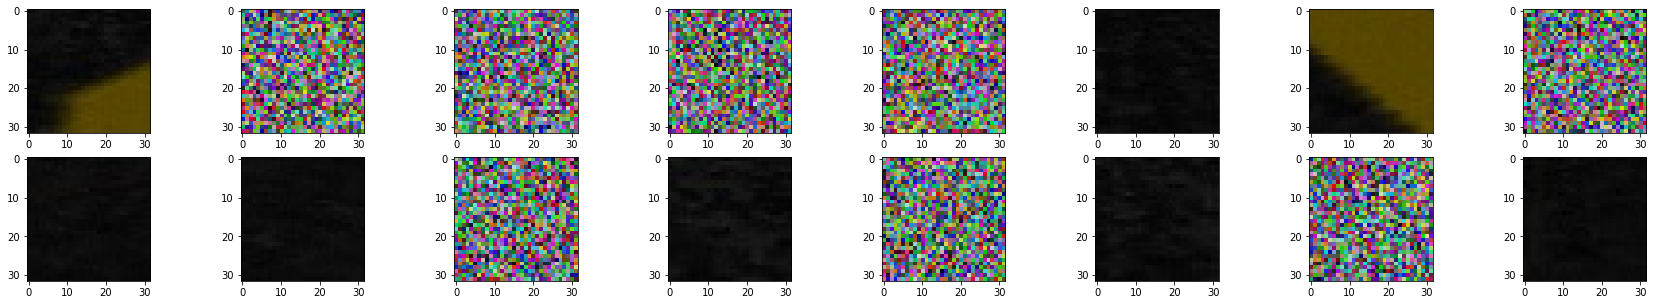

In [5]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(patches[i]))

### Build Model

In [6]:
class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 32, 32)):
        super(NavNet, self).__init__()
        
        self.input_conv = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten()
        )
        
        fc_dims = self.input_conv(torch.zeros(input_shape).unsqueeze(0)).shape[1]
        
        self.fc1 = nn.Linear(fc_dims, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, left_patch):
        conv_output = self.input_conv(left_patch)
        fc1_output = F.relu(self.fc1(conv_output))
        fc2_output = F.relu(self.fc2(fc1_output))
        final_output = torch.sigmoid(self.fc3(fc2_output))
        return final_output

In [13]:
navnet = NavNet()
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)

Model Size:  112193


### Train Model

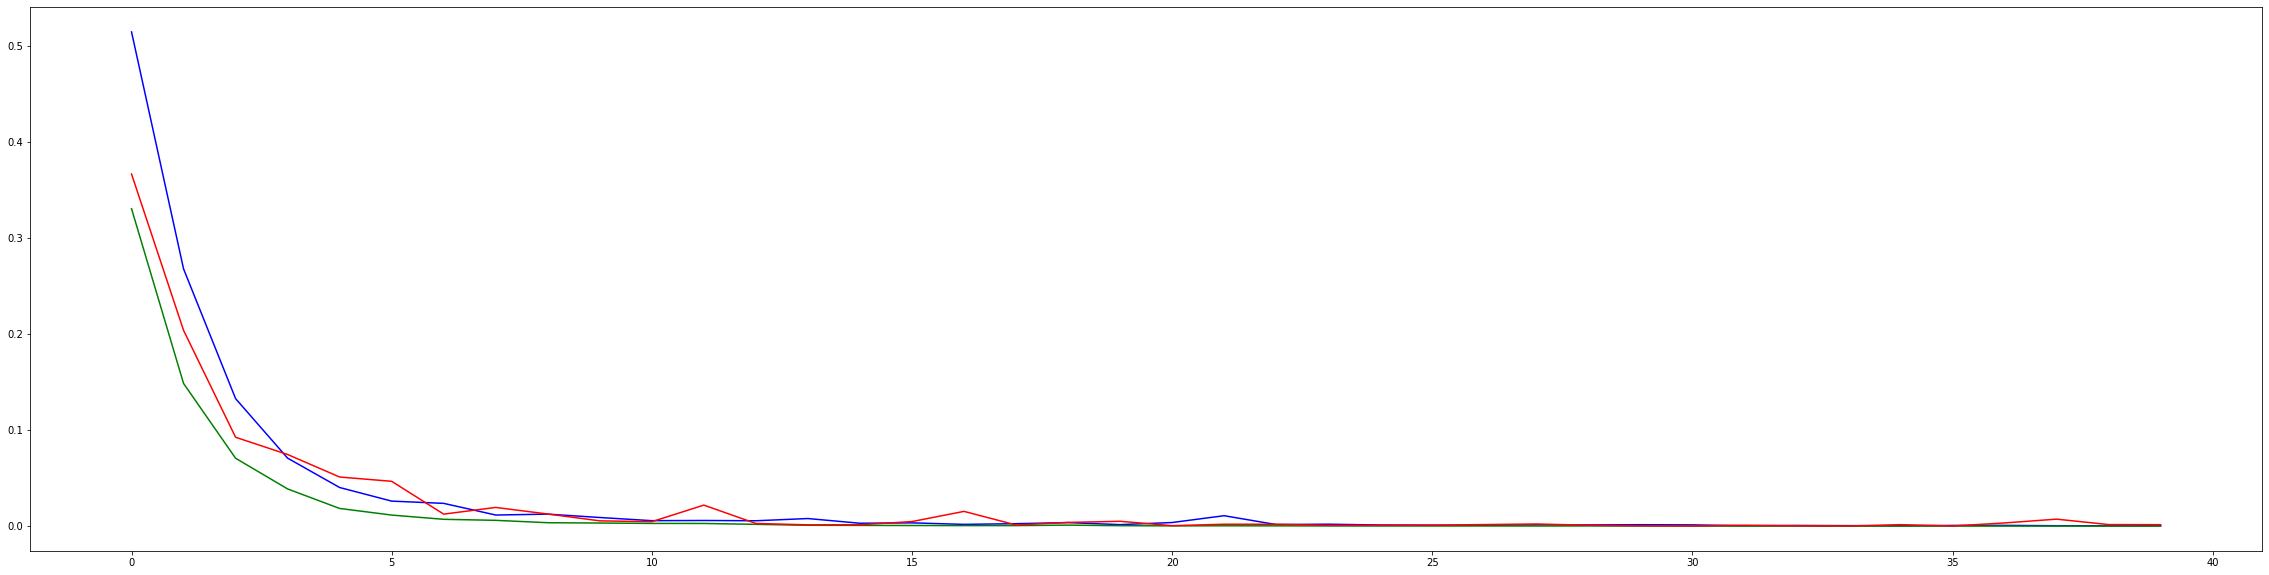

[0.51488321185112, 0.2680009016394615, 0.13284167066216468, 0.07082707680761814, 0.040228541046380996, 0.026062190979719162, 0.023707832610234618, 0.011563073713332414, 0.012498949272558093, 0.00898450226522982, 0.0056903779553249476, 0.0058934575784951445, 0.005590885826386512, 0.007908690323820338, 0.003000344665488228, 0.0033956815325655045, 0.001832393144723028, 0.002546980636543594, 0.003670020119752735, 0.001556675210595131, 0.0037519464921206237, 0.010855361217400059, 0.0016471510039991698, 0.0020036054533557036, 0.0011919686043984257, 0.0010130626952741294, 0.0008849574413034133, 0.001295636762661161, 0.0012681634072214366, 0.001483640226215357, 0.0013008826893928925, 0.0004272677081462461, 0.0007247457151242998, 0.0005093139838572825, 0.00037270407352480106, 0.0007324343544314615, 0.0007807521162612829, 0.00043307856023602656, 0.00035188434994779525, 0.00042509291881287937]
#########
[0.33070834577083585, 0.1486530289053917, 0.07071668319404126, 0.03875165805220604, 0.01840958

In [12]:
from IPython.display import clear_output

num_epochs = 40
train_steps_per_epoch = 50
test_steps_per_epoch = 10
batch_size = 16

collision_buffer = 35
path_length = 30

# For visualization 
focal_length = 190.68
baseline = 0.2
scale = 5

# Make Model
navnet = NavNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)

train_batch_gen = batch_generator(train_data, patch_shape=(3,32,32), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_normal_batch_gen = batch_generator(test_normal_data, patch_shape=(3,32,32), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_anormal_batch_gen = batch_generator(test_anormal_data, patch_shape=(3,32,32), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)

train_loss = []
normal_test_loss = []
anormal_test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    navnet.train()
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        patches, labels = next(train_batch_gen)
        output = navnet(patches.to(device))
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Normal / Anormal testing
    
    # Normal
    navnet.eval()
    avg_normal_test_loss = 0
    for step in range(test_steps_per_epoch):
        patches, labels = next(test_normal_batch_gen)
        output = navnet(patches.to(device))
        loss = criterion(output, labels.to(device))
        avg_normal_test_loss += loss.item()
        
    avg_normal_test_loss /= test_steps_per_epoch
    normal_test_loss.append(avg_normal_test_loss)
    
    # Anormal
    avg_anormal_test_loss = 0
    navnet.eval()
    for step in range(test_steps_per_epoch):
        patches, labels = next(test_anormal_batch_gen)
        output = navnet(patches.to(device))
        loss = criterion(output, labels.to(device))
        avg_anormal_test_loss += loss.item()
        
    avg_anormal_test_loss /= test_steps_per_epoch
    anormal_test_loss.append(avg_anormal_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,1,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(normal_test_loss,  color='green', label='normal test loss')
    plt.plot(anormal_test_loss,  color='red', label='anormal test loss')
    
    plt.show()
    
print(train_loss)
print("#########")
print(normal_test_loss)
print("#########")
print(anormal_test_loss)

### Visualize Model

In [9]:
def transform_img_with_disp(disp, right_image): 
    batch_size, _, height, width = right_image.size()

    # For applying disparities to images
    x_base = torch.linspace(-1, 1, width).repeat(batch_size, height, 1).type_as(disp) # shape  = Nxheightxwidth
    y_base = torch.linspace(-1, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type_as(disp) 

    flow_feild = torch.stack((x_base+disp[:,0,:,:], y_base), dim=3)
    return F.grid_sample(right_image, flow_feild, align_corners=False)

In [11]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.005
crop_line = 90

focal_length = 190.68
baseline = 0.2

navnet.eval()
dataset = test_normal_data
for i in range(1, len(dataset.data)):
    left_img = dataset.read_torch_image(i).unsqueeze(0).to(device)
    right_img = dataset.read_torch_image(i, right=True).unsqueeze(0).to(device)
    if len(left_img) > 0:
        cv_image = dataset.read_cv_image(i)

        model_output = navnet(left_img)
        
        transformed_left_image = transform_img_with_disp(model_output, right_img)
        np_transformed_img = utils.torch_image_to_cv_image(transformed_left_image[0].cpu().detach())

        heat_map = ((cv_image/255-np_transformed_img)**2)
#             ssim_left = torch.mean(self.SSIM(left_images, shifted_right_to_left)) 
#         loss_rl = alpha*ssim_left+(1-alpha)*left_l1_loss

        mask = np.sum(heat_map, axis=2)
        mask = (mask > threshold).astype(int)

        if loss > threshold:
            score = 1
        else:
            score = 0
            
        red = np.ones((cv_image.shape[0], cv_image.shape[1])) * mask
        green = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - mask)
        color_mask = np.zeros(cv_image.shape)
        color_mask[:,:,0] = red
        color_mask[:,:,1] = green
        color_mask = (color_mask*255).astype('uint8')
        
        color_mask = cv2.medianBlur(color_mask,17)
        masked_image = cv2.addWeighted(cv_image,0.7,color_mask,0.3,0)  
        
        
        # Depth map
        depth_map = focal_length*baseline/((model_output[0,0]*320).cpu().detach().numpy())
        depth_map = np.clip(depth_map, 0, scale)/scale
        depth_img = cv2.applyColorMap((depth_map*255).astype('uint8'), cv2.COLORMAP_JET);        
        
        display_img = np.hstack((masked_image, (np_transformed_img*255).astype('uint8'), depth_img))
        
        cv2.imshow('image', cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        cv2.waitKey(50)

KeyboardInterrupt: 

### Save Model

In [12]:
# Standard pytorch model saving/loading
name = "navnet-v3"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>